In [17]:
from pylab import cm
from sklearn import metrics
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.visualization import circuit_drawer
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap, ZFeatureMap
from qiskit_algorithms.optimizers import SPSA
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel, TrainableKernel, FidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.algorithms import QSVR
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_algorithms.utils import algorithm_globals
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import datasets
from qiskit_machine_learning.utils.loss_functions import KernelLoss, SVCLoss
from typing import Sequence
from sklearn.svm import SVC, SVR
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_circles, make_moons, make_blobs


In [18]:
class QKTCallback:
    """Callback wrapper class."""

    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        """
        Args:
            x0: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        """
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]


def _make_circular_data(num_sectors):
    """Generate datapoints arranged in an even circle."""
    center_indices = np.array(range(0, num_sectors))
    sector_angle = 2 * np.pi / num_sectors
    angles = (center_indices + 0.5) * sector_angle
    x = 0.7 * np.cos(angles)
    y = 0.7 * np.sin(angles)
    labels = 2 * np.remainder(np.floor_divide(angles, sector_angle), 2) - 1

    return x, y, labels


def make_double_cake_data(num_sectors):
    x1, y1, labels1 = _make_circular_data(num_sectors)
    x2, y2, labels2 = _make_circular_data(num_sectors)

    # x and y coordinates of the datapoints
    x = np.hstack([x1, 0.5 * x2])
    y = np.hstack([y1, 0.5 * y2])

    # Canonical form of dataset
    X = np.vstack([x, y]).T

    labels = np.hstack([labels1, -1 * labels2])

    # Canonical form of labels
    Y = labels.astype(int)

    return X, Y

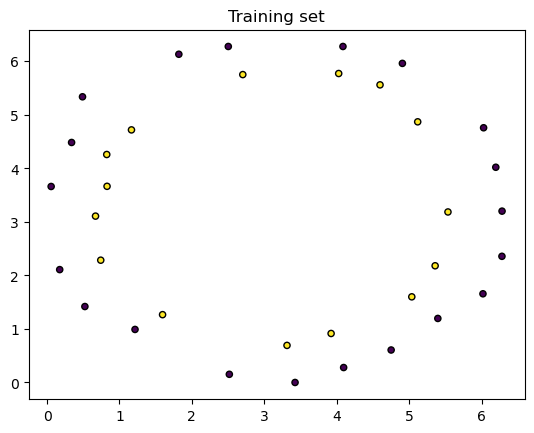

In [19]:
X, y = make_circles(n_samples=50, factor=0.8, noise=0.025, random_state=42)
feature_dimension=2
#select which class and features to use
#class1 = 0
#class2 = 2
#feature1 = 0
#feature2 = 3
#
#iris = datasets.load_iris()
#
#X = iris.data[:, [feature1, feature2]]
#y = iris.target
#
#X = X[np.logical_or(y == class1, y == class2)]
#y = y[np.logical_or(y == class1, y == class2)]

X = MinMaxScaler(feature_range=(0, 2*np.pi)).fit_transform(X) #seems to have better results if compatible with the rotation encoding
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=13) 

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20, edgecolor='k')
plt.title('Training set')
plt.show()

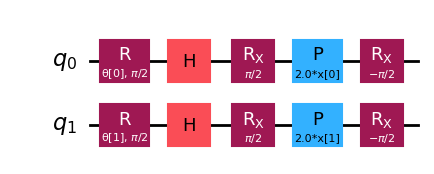

In [20]:
training_params = ParameterVector("θ", 2)
feature_map0 = QuantumCircuit(feature_dimension)
feature_map0.ry(training_params[0], 0)
feature_map0.ry(training_params[1], 1)
#feature_map0 = PauliFeatureMap(feature_dimension=feature_dimension, reps=1, paulis=['Y'])
#feature_map=ZZFeatureMap(feature_dimension, reps=1)
feature_map1 = PauliFeatureMap(feature_dimension=feature_dimension, reps=1, paulis=['Y'])
feature_map0.assign_parameters(training_params, inplace=True)
feature_map = feature_map0.compose(feature_map1)
feature_map.decompose().draw('mpl')

In [21]:
kernel = TrainableFidelityQuantumKernel(feature_map=feature_map, training_parameters=training_params)
cb_qkt = QKTCallback()
spsa_opt = SPSA(maxiter=20, callback=cb_qkt.callback, learning_rate=0.05, perturbation=0.05)
loss = SVCLoss()
qkt = QuantumKernelTrainer(quantum_kernel=kernel, loss=loss, optimizer=spsa_opt)

In [22]:
qka_results = qkt.fit(X_train, y_train)
optimized_kernel = qka_results.quantum_kernel
print(qka_results)

{   'optimal_circuit': None,
    'optimal_parameters': {   ParameterVectorElement(θ[1]): 0.7766862405989108,
                              ParameterVectorElement(θ[0]): 0.2482791134524952},
    'optimal_point': array([0.24827911, 0.77668624]),
    'optimal_value': 22.056596446884008,
    'optimizer_evals': 60,
    'optimizer_result': None,
    'optimizer_time': None,
    'quantum_kernel': <qiskit_machine_learning.kernels.trainable_fidelity_quantum_kernel.TrainableFidelityQuantumKernel object at 0x79e1813b1460>}


Accuracy:  0.4666666666666667


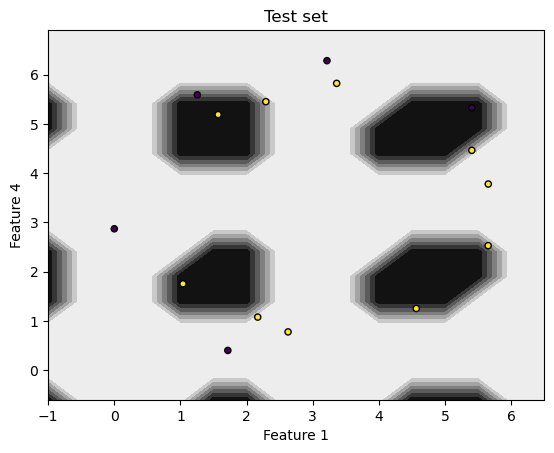

In [23]:
#fit classical SVR with optimized quantum kernel
svm = SVC(kernel=optimized_kernel.evaluate) 
svm.fit(X_train, y_train)

print('Accuracy: ', svm.score(X_test, y_test))
#plot decision boundary
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5), np.arange(y_min, y_max, 0.5))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap='binary')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=20, edgecolor='k')
plt.xlabel(f'Feature {feature1+1}')
plt.ylabel(f'Feature {feature2+1}')
plt.title('Test set')
plt.show()

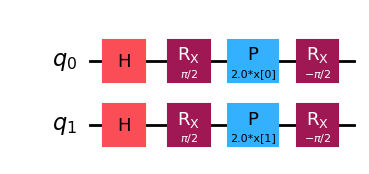

In [24]:
feature_map = PauliFeatureMap(feature_dimension=feature_dimension, reps=1, paulis=['Y'])
feature_map.decompose().draw('mpl')

Accuracy:  0.4666666666666667


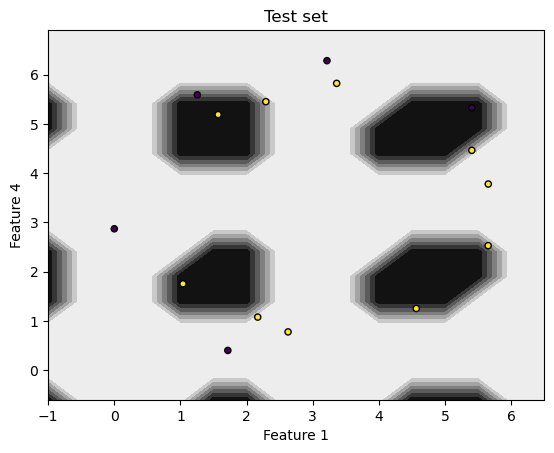

In [25]:
#fit classical SVR with NOT optimized quantum kernel
kernel = FidelityQuantumKernel(feature_map=feature_map)
svm = SVC(kernel=kernel.evaluate) 
svm.fit(X_train, y_train)

print('Accuracy: ', svm.score(X_test, y_test))
#plot decision boundary
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5), np.arange(y_min, y_max, 0.5))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap='binary')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=20, edgecolor='k')
plt.xlabel(f'Feature {feature1+1}')
plt.ylabel(f'Feature {feature2+1}')
plt.title('Test set')
plt.show()

Accuracy:  0.3333333333333333


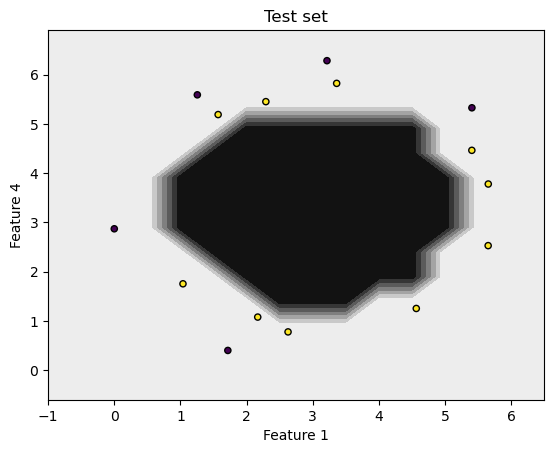

In [26]:
#fit classical SVR with rbf kernel
svm = SVC(kernel='rbf') 
svm.fit(X_train, y_train)

print('Accuracy: ', svm.score(X_test, y_test))
#plot decision boundary
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5), np.arange(y_min, y_max, 0.5))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap='binary')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=20, edgecolor='k')
plt.xlabel(f'Feature {feature1+1}')
plt.ylabel(f'Feature {feature2+1}')
plt.title('Test set')
plt.show()

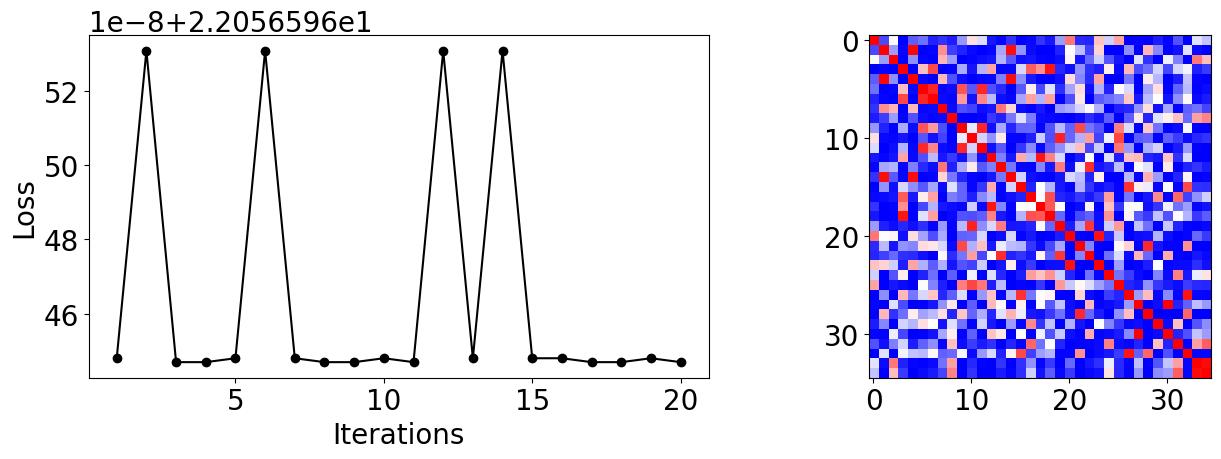

In [27]:
plot_data = cb_qkt.get_callback_data()  # callback data
K = optimized_kernel.evaluate(X_train)  # kernel matrix evaluated on the training samples

plt.rcParams["font.size"] = 20
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[1].imshow(K, cmap=matplotlib.colormaps["bwr"])
fig.tight_layout()
plt.show()